In [2]:
# Matthew Irvin
# WGU Capstone Task 3
# Correlation Between Strength Training and Income in the United States

# Import libraries and tools for data handling, stats, and visuals
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm

### Capstone Analysis - Strength Training and Income in the United States

This notebook explores whether higher income levels are linked to stronger participation in strength-training activities.  
The data comes from the CDC’s Behavioral Risk Factor Surveillance System (BRFSS), a national survey that tracks health and lifestyle patterns.  

We’ll clean the dataset, narrow it to the “muscle-strengthening” question, and analyze how income brackets correlate with activity rates.  
Each data point here represents thousands of adults grouped by income, giving us a reliable, national snapshot of how exercise and earnings connect.

In [4]:
# Read CDC dataset into a DataFrame
df = pd.read_csv("Untitled Folder/Nutrition__Physical_Activity__and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System 2.csv")

In [5]:
df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,Datasource,Class,Topic,Question,Data_Value_Unit,Data_Value_Type,...,GeoLocation,ClassID,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(32.84057112200048, -86.63186076199969)",OWS,OWS1,Q036,VALUE,1,Total,Total,OVR,OVERALL
1,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(32.84057112200048, -86.63186076199969)",OWS,OWS1,Q036,VALUE,1,Gender,Male,GEN,MALE
2,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(32.84057112200048, -86.63186076199969)",OWS,OWS1,Q036,VALUE,1,Gender,Female,GEN,FEMALE
3,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(32.84057112200048, -86.63186076199969)",OWS,OWS1,Q036,VALUE,1,Education,Less than high school,EDU,EDUHS
4,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(32.84057112200048, -86.63186076199969)",OWS,OWS1,Q036,VALUE,1,Education,High school graduate,EDU,EDUHSGRAD


In [45]:
# Preview for Presentation of columns used ( muscle-strengthening question/income stratification )
df_strength_preview = df[
    (df["Question"].str.contains("muscle-strengthening", case=False, na=False)) &
    (df["StratificationCategory1"].str.contains("Income", case=False, na=False))
][["Question", "StratificationCategory1", "Stratification1"]].head(10)

pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 200)
df_strength_preview


,Question,StratificationCategory1,Stratification1
156,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Income,"Less than $15,000"
157,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Income,"$15,000 - $24,999"
158,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Income,"$25,000 - $34,999"
159,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Income,"$35,000 - $49,999"
160,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Income,"$50,000 - $74,999"
161,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Income,"$75,000 or greater"
162,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Income,Data not reported
200,Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Income,"$25,000 - $34,999"
207,Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Income,"Less than $15,000"
213,Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Income,Data not reported


In [7]:
df.shape

(53392, 33)

### Main Analysis: Income vs Strength Training Participation  
This section looks at how strength-training habits change across income groups.  
After filtering for the CDC’s “muscle-strengthening” question, we averaged the results within each income bracket to create a clean summary dataset.  

Then, a Pearson correlation and simple linear regression were used to measure how closely income and training frequency move together.  
Higher income groups clearly show higher participation, and the regression line quantifies that upward trend.


In [9]:
# Filters rows for the strength-training questions only
mask = df["Question"].str.contains("muscle-strengthening", case=False, na=False)
df_strength = df[mask]
# Keep only the records that compare results by income
df_strength = df_strength[df_strength["StratificationCategory1"].str.contains("Income", case=False, na=False)]
# Keep useful columns & drop missing values
## **

df_strength = df_strength[["Stratification1", "Data_Value"]].dropna()
# Average data within each income group. Aggregated across all states and years
df_income = df_strength.groupby("Stratification1")["Data_Value"].mean().reset_index()

In [10]:
# Convert income brackets to numeric midpoints
def income_midpoint(value):
    value = str(value)
    if "Less" in value:
        return 7500
    elif "15,000" in value and "24,999" in value:
        return 20000
    elif "25,000" in value and "34,999" in value:
        return 30000
    elif "35,000" in value and "49,999" in value:
        return 42500
    elif "50,000" in value and "74,999" in value:
        return 62500
    elif "75,000" in value:
        return 90000
    elif "100,000" in value:
        return 110000
    else:
        return np.nan

# Add numeric income values/sort
df_income["Income_Midpoint"] = df_income["Stratification1"].apply(income_midpoint)
df_income = df_income.dropna(subset=["Income_Midpoint"])

In [11]:
df_income = df_income.sort_values("Income_Midpoint")

In [12]:
# Preview of filtered and cleaned data
df_preview = df_income[["Stratification1", "Income_Midpoint", "Data_Value"]].rename(
    columns={
        "Stratification1": "Income Bracket",
        "Data_Value": "Adults who Strength Train by %"
    }
).head(10)

df_preview


,Income Bracket,Income_Midpoint,Adults who Strength Train by %
6,"Less than $15,000",7500.0,19.008228
0,"$15,000 - $24,999",20000.0,20.275949
1,"$25,000 - $34,999",30000.0,22.113608
2,"$35,000 - $49,999",42500.0,24.181329
3,"$50,000 - $74,999",62500.0,26.317089
4,"$75,000 or greater",90000.0,31.138608


In [13]:
##@@


In [14]:
# Linear relationship strength (Pearson correlation)
r, p = pearsonr(df_income["Income_Midpoint"], df_income["Data_Value"])
print(f"Pearson correlation coefficient (r): {r:.4f}")
print(f"P-value: {p:.4f}")

Pearson correlation coefficient (r): 0.9970
P-value: 0.0000


In [15]:
# Simple OLS regression model
X = sm.add_constant(df_income["Income_Midpoint"])
y = df_income["Data_Value"]
model = sm.OLS(y, X).fit()
print(model.summary())

from scipy.stats import spearmanr
rho, p_s = spearmanr(df_income["Income_Midpoint"], df_income["Data_Value"])
print(f"Spearman correlation (rho): {rho:.3f}, p-value: {p_s:.4g}")

# Refit OLS with robust standard errors (HC3)
ols_robust = sm.OLS(y, X).fit().get_robustcov_results(cov_type="HC3")
print("\nOLS with robust (HC3) SEs:\n")
print(ols_robust.summary())


                            OLS Regression Results                            
Dep. Variable:             Data_Value   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     669.8
Date:                Sun, 09 Nov 2025   Prob (F-statistic):           1.32e-05
Time:                        09:25:59   Log-Likelihood:                -1.5300
No. Observations:                   6   AIC:                             7.060
Df Residuals:                       4   BIC:                             6.644
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              17.6591      0.285     

/opt/anaconda3/envs/dsnd-pipelines/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/opt/anaconda3/envs/dsnd-pipelines/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


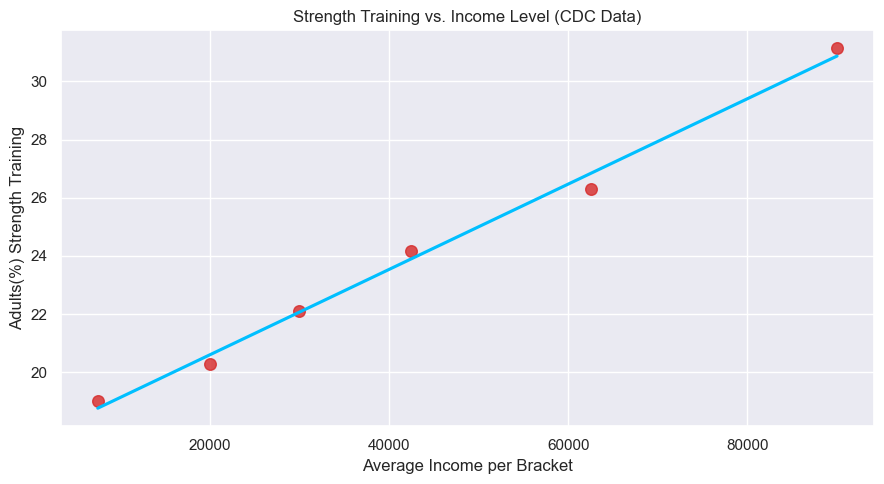

In [16]:
sns.set(style="darkgrid")
plt.figure(figsize=(9,5))
sns.regplot(x="Income_Midpoint", y="Data_Value", data=df_income, ci=None, color="deepskyblue", scatter_kws={"s":70, "color":"#D62828"})
plt.title("Strength Training vs. Income Level (CDC Data)")
plt.xlabel("Average Income per Bracket")
plt.ylabel("Adults(%) Strength Training")
plt.tight_layout()
plt.show()

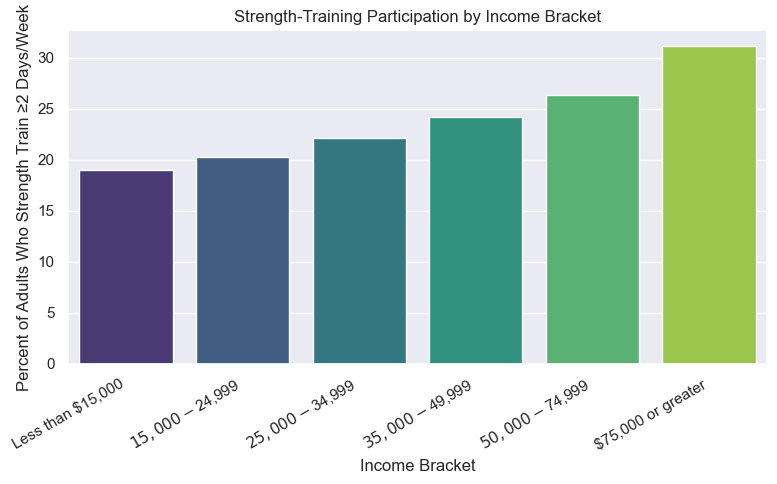

In [17]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=df_income,
    x="Stratification1", y="Data_Value",
    hue="Stratification1", palette="viridis", legend=False
)

plt.title("Strength-Training Participation by Income Bracket")
plt.xlabel("Income Bracket")
plt.ylabel("Percent of Adults Who Strength Train ≥2 Days/Week")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


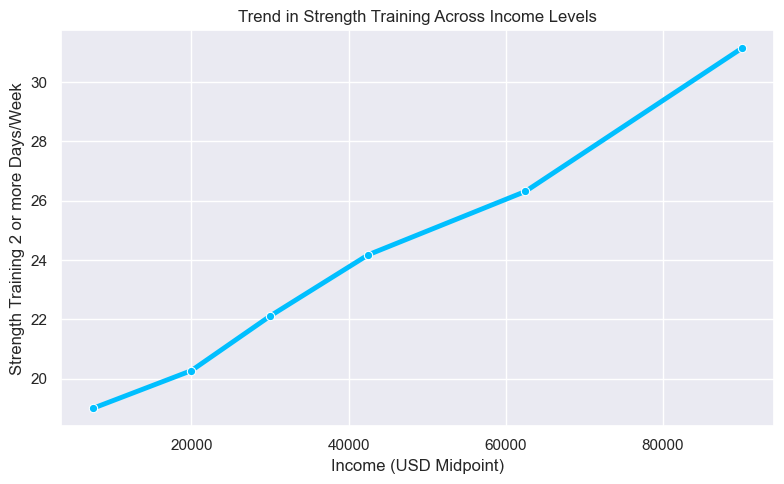

In [18]:
plt.figure(figsize=(8,5))
sns.lineplot(
    data=df_income.sort_values("Income_Midpoint"),
    x="Income_Midpoint", y="Data_Value",
    marker="o", linewidth=3.5, color="deepskyblue"
)
plt.title("Trend in Strength Training Across Income Levels")
plt.xlabel("Income (USD Midpoint)")
plt.ylabel("Strength Training 2 or more Days/Week")
plt.tight_layout()
plt.show()



### Secondary Analysis - Inactivity vs Income  
To test the pattern from another angle, we analyzed the inverse. Adults reporting *"no leisure-time physical activity"*.  
Using the same income brackets, we found that inactivity rates consistently drop as income rises.  

This produces a strong negative correlation, mirroring the strength-training trend in reverse.  
Together, the two analyses highlight a clear divide: higher-income adults are more likely to stay active, while lower-income groups report more inactivity.

In [20]:
# SECOND ANALYSIS — No Physical Activity vs Income

# Filter for inactivity question ("no leisure-time physical activity")
mask_no = df["Question"].str.contains("no leisure-time physical activity", case=False, na=False)
df_inactive = df[mask_no]

# Keep only income comparisons
df_inactive = df_inactive[df_inactive["StratificationCategory1"].str.contains("Income", case=False, na=False)]

# Select key columns and clean up
df_inactive = df_inactive[["Stratification1", "Data_Value"]].dropna()

# Aggregate averages per income bracket
df_inactive = df_inactive.groupby("Stratification1")["Data_Value"].mean().reset_index()

# Add midpoints for numeric comparison
df_inactive["Income_Midpoint"] = df_inactive["Stratification1"].apply(income_midpoint)
df_inactive = df_inactive.dropna(subset=["Income_Midpoint"]).sort_values("Income_Midpoint")

# Run correlation and regression for inactivity
r2, p2 = pearsonr(df_inactive["Income_Midpoint"], df_inactive["Data_Value"])
print(f"Pearson correlation (r): {r2:.3f}, p-value: {p2:.4f}")

X2 = sm.add_constant(df_inactive["Income_Midpoint"])
y2 = df_inactive["Data_Value"]
model2 = sm.OLS(y2, X2).fit()
print(model2.summary())


Pearson correlation (r): -0.991, p-value: 0.0001
                            OLS Regression Results                            
Dep. Variable:             Data_Value   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     229.9
Date:                Sun, 09 Nov 2025   Prob (F-statistic):           0.000110
Time:                        09:25:59   Log-Likelihood:                -8.4319
No. Observations:                   6   AIC:                             20.86
Df Residuals:                       4   BIC:                             20.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

/opt/anaconda3/envs/dsnd-pipelines/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


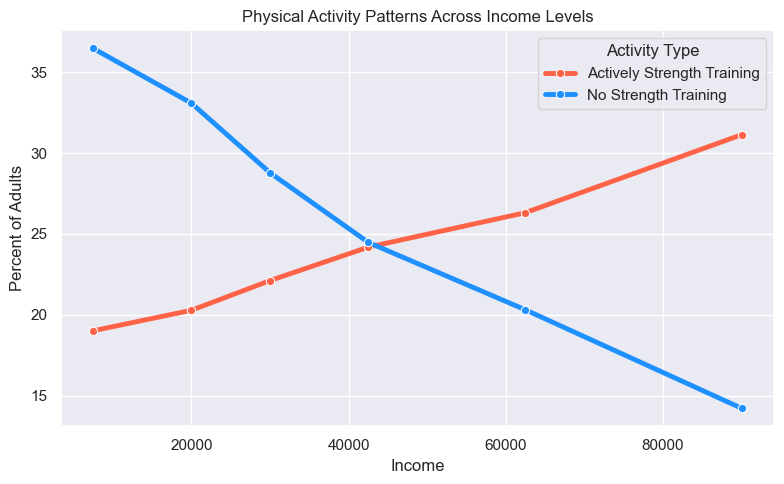

In [21]:
# COMPARISON PLOT to visualize Active vs Inactive Trends by Income

# Combine active and inactive data for side-by-side visualization
df_compare = pd.merge(
    df_income[["Income_Midpoint", "Data_Value"]],
    df_inactive[["Income_Midpoint", "Data_Value"]],
    on="Income_Midpoint",
    suffixes=("_Active", "_Inactive")
)

# Reformat for Seaborn plotting
df_long = df_compare.melt(
    id_vars="Income_Midpoint",
    value_vars=["Data_Value_Active", "Data_Value_Inactive"],
    var_name="Activity_Type",
    value_name="Percent"
)

# Rename columns for clarity
df_long["Activity_Type"] = df_long["Activity_Type"].replace({
    "Data_Value_Active": "Actively Strength Training",
    "Data_Value_Inactive": "No Strength Training"
})

# 4. Plot both lines
plt.figure(figsize=(8,5))
sns.lineplot(
    data=df_long,
    x="Income_Midpoint",
    y="Percent",
    hue="Activity_Type",
    marker="o",
    palette=["tomato", "dodgerblue"],
    linewidth=3.5
)
plt.title("Physical Activity Patterns Across Income Levels")
plt.xlabel("Income")
plt.ylabel("Percent of Adults")
plt.legend(title="Activity Type")
plt.tight_layout()
plt.show()


### Final Insights/Takeaways  

The analysis paints a consistent picture: as income rises, structured exercise like strength training becomes more common, while inactivity falls sharply.  
The near-perfect correlations in both directions make the pattern impossible to ignore.  

Still, these results come from aggregated survey averages, not individuals, so they should be read as broad trends rather than precise predictions.  
In real life, there are many other factors to consider such as time, access, and motivation that may influence whether someone stays active.  
The data highlights a meaningful connection between financial success and personal health habits.  
My interpretation is this: higher-income adults seem to invest in themselves more physically and financially, while lower-income groups face more barriers to regular exercise.


In [23]:
# Save outputs to file for project
df_income.to_csv("correlation_table.csv", index=False)
plt.savefig("scatter_regression.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>